<a href="https://colab.research.google.com/github/munindra2132/Colorize_B-W_pictures/blob/main/Colorization_of_BW_pictures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The below code is used to colorize black and white pictures using Deep Learning with Keras Tensorflow

#Importing libraries 

In [ ]:
import keras
from keras.preprocessing import image
#from keras.engine import Layer
from keras.layers import Conv2D, Conv3D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge,concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.callbacks import TensorBoard

from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
from time import time
import numpy as np
import os
import random
import tensorflow as tf
from PIL import Image, ImageFile


# Loading the data 

Connecting to Google Drive to access the image dataset which may require to sign in the corresponding google account

In [ ]:
from google.colab import drive
drive.mount('/Munindra')

Specifying the location in Google Drive for the Image dataset

In [ ]:
path='/Munindra/MyDrive/ImageDataset/'
train_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
train = train_datagen.flow_from_directory(path, target_size=(256,256),class_mode=None)

# Preprocessing Images

An Image consists of 3 channels mainly Red Green Blue(RGB) which if combined with each other shows us the real image what is seen by our eyes. The main problem to colorize is to generate 3 channels from a single channel which is Black and White. 

Thus to avoid this problem we rather use Lab instead of RGB to define a image where *L* is reponsible for lightness(grayscale) or luminosity and *ab* is responsible for colors. This idea comes from the fact that human eyes contains around 94% receptors which is sensitive to light and around 6 % for the visualization of the colors. The shown diagram shows how an image will look if broken down into Lab format.

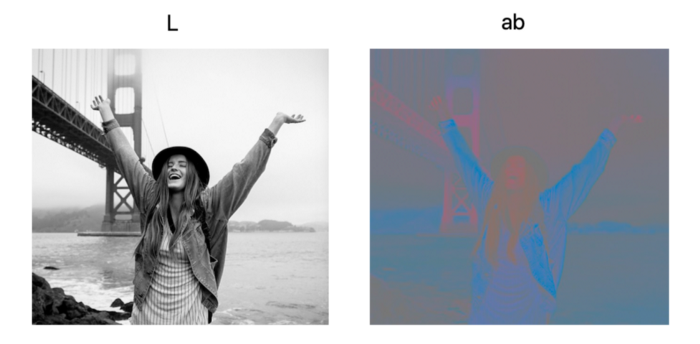

Converting RGB images to Lab format which will be used to train the model

In [ ]:
X = []
Y = []
for img in train[0]:
  try:
    lab = rgb2lab(img)
    X.append(lab[:,:,0])
    Y.append(lab[:,:,1:]/128)
  except:
    print('Error')

X = np.array(X)
Y = np.array(Y)

X = X.reshape(X.shape+(1,))
print(X.shape)
print(Y.shape)

(32, 256, 256, 1)
(32, 256, 256, 2)


# Defining the Model

We will be using **Autoencoders** to achieve our goal. 

What is an Autoencoder ?

An Auto-encoder is a neural network that is trained to attempt to copy its input to its output. This network consists of 2 parts namely enocoder function h = f(x) and a decoder that produces a reconstruction r = g(h). They are designed to be unable to learn to copy perfectly. They are trained in ways that allow them to copy only approximately and to copy only input that resembles the training data.

Code for encoder which involves a no. of convolutaions which extracts features from the Lab image

In [ ]:
#Encoder
encoder_input = Input(shape=(256,256,1))
encoder_output = Conv2D( 64,(3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128,(3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256,(3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256,(3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512,(3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512,(3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256,(3,3), activation='relu', padding='same')(encoder_output)



Code for Decoder which involves Convolutions and UpSampling

In [ ]:
#Decoder
decoder_output = Conv2D(128,(3,3), activation='relu',padding='same')(encoder_output)
decoder_output = UpSampling2D((2,2))(decoder_output)
decoder_output = Conv2D( 64,(3,3), activation='relu',padding='same')(decoder_output)
decoder_output = UpSampling2D((2,2))(decoder_output)
decoder_output = Conv2D( 32,(3,3), activation='relu',padding='same')(decoder_output)
decoder_output = Conv2D( 16,(3,3), activation='relu',padding='same')(decoder_output)
decoder_output = Conv2D( 2,(3,3), activation='tanh',padding='same')(decoder_output)
#decoder_output = UpSampling2D((2,2))(decoder_output)
model = Model(inputs = encoder_input,outputs=decoder_output)

#Model Summary

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 256)     295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 256)       590080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 512)       1180160   
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 512)       235980

Training the Model with **Mean Square Error** as loss function and ***Adam*** as our Optimizer functions with 1000 epochs and validation split of 20%

In [ ]:
model.compile(optimizer='adam', loss=['mse','mse'], metrics=['accuracy'])
model.fit(X,Y,validation_split=0.2,epochs=1000)

# Testing

Testing the model using some images which are present in the google drive and storing them in google drive

In [ ]:
test_path = '/Munindra/MyDrive/ImageDataset/Test/'
test= os.listdir(test_path)
color_me= []
for imgName in test:
  img = img_to_array(load_img(test_path + imgName))
  img = resize(img,(256,256))
  color_me.append(img)
print(len(color_me))
color_me = np.array(color_me, dtype=float)
print(color_me.shape)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))
print(color_me.shape)

20
(20, 256, 256, 3)
(20, 256, 256, 1)


In [ ]:
output = model.predict(color_me)
output = output * 128

The output of the model is stored in ***output*** variable which is again transformed from Lab to RGB format 

In [ ]:
#Output Colorizations
for i in range(len(output)):
  result = np.zeros((256,256,3))
  result[:,:,0] = color_me[i][:,:,0]
  result[:,:,1:] = output[i]
  s = str(i)
  print(i)
  imsave("/Munindra/MyDrive/ImageDataset/result"+s+".png",lab2rgb(result))